# Forecast for Energy Mix

## 1.Setup

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests
!pip install skforecast
# !pip install scikit-learn==1.2
# !pip install pycaret

clear_output()

In [ ]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
from retry_requests import retry
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.datasets import fetch_dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# from pycaret.regression import *

# Import libraries
import requests
import pandas as pd
from datetime import datetime, timedelta, date
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pytz

In [ ]:
google_drive_path = "/content/drive/MyDrive/LINC/"

In [ ]:
# Backtesting with custom metric
# ==============================================================================
def custom_mape(y_true, y_pred):
    mape = (np.abs(y_pred - y_true) / np.abs(y_true)).map(lambda x: 0 if math.isnan(x) else x)
    mape = mape.map(lambda x: 1 if math.isinf(x) else x)
    return np.mean(mape)

In [ ]:
# Backtesting with custom metric
# ==============================================================================
def custom_smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))

## 2.Create the dataset

### 2.1. Retrieving historical weather data

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [ ]:
def get_cy_weather_historical(lati, longi, suffix):

  url = "https://archive-api.open-meteo.com/v1/archive"

  params = {
	  "latitude": lati,
	  "longitude": longi,
	  "start_date": "2023-01-01",
	  "end_date": "2024-05-30",
    "hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m", "is_day", "sunshine_duration", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "terrestrial_radiation_instant"],
	  "timezone": "Europe/Moscow"
  }

  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
  hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
  hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
  hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
  hourly_rain = hourly.Variables(4).ValuesAsNumpy()
  hourly_pressure_msl = hourly.Variables(5).ValuesAsNumpy()
  hourly_surface_pressure = hourly.Variables(6).ValuesAsNumpy()
  hourly_cloud_cover = hourly.Variables(7).ValuesAsNumpy()
  hourly_cloud_cover_low = hourly.Variables(8).ValuesAsNumpy()
  hourly_cloud_cover_mid = hourly.Variables(9).ValuesAsNumpy()
  hourly_cloud_cover_high = hourly.Variables(10).ValuesAsNumpy()
  hourly_wind_speed_10m = hourly.Variables(11).ValuesAsNumpy()
  hourly_wind_speed_100m = hourly.Variables(12).ValuesAsNumpy()
  hourly_wind_direction_10m = hourly.Variables(13).ValuesAsNumpy()
  hourly_wind_direction_100m = hourly.Variables(14).ValuesAsNumpy()
  hourly_wind_gusts_10m = hourly.Variables(15).ValuesAsNumpy()
  hourly_is_day = hourly.Variables(16).ValuesAsNumpy()
  hourly_sunshine_duration = hourly.Variables(17).ValuesAsNumpy()
  hourly_shortwave_radiation = hourly.Variables(18).ValuesAsNumpy()
  hourly_direct_radiation = hourly.Variables(19).ValuesAsNumpy()
  hourly_diffuse_radiation = hourly.Variables(20).ValuesAsNumpy()
  hourly_direct_normal_irradiance = hourly.Variables(21).ValuesAsNumpy()
  hourly_terrestrial_radiation = hourly.Variables(22).ValuesAsNumpy()
  hourly_shortwave_radiation_instant = hourly.Variables(23).ValuesAsNumpy()
  hourly_direct_radiation_instant = hourly.Variables(24).ValuesAsNumpy()
  hourly_diffuse_radiation_instant = hourly.Variables(25).ValuesAsNumpy()
  hourly_direct_normal_irradiance_instant = hourly.Variables(26).ValuesAsNumpy()
  hourly_terrestrial_radiation_instant = hourly.Variables(27).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
	  start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	  end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	  freq = pd.Timedelta(seconds = hourly.Interval()),
	  inclusive = "left"
  )}

  hourly_data["temperature_2m"] = hourly_temperature_2m
  hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
  hourly_data["apparent_temperature"] = hourly_apparent_temperature
  hourly_data["precipitation"] = hourly_precipitation
  hourly_data["rain"] = hourly_rain
  hourly_data["pressure_msl"] = hourly_pressure_msl
  hourly_data["surface_pressure"] = hourly_surface_pressure
  hourly_data["cloud_cover"] = hourly_cloud_cover
  hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
  hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
  hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
  hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
  hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
  hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
  hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
  hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
  hourly_data["is_day"] = hourly_is_day
  hourly_data["sunshine_duration"] = hourly_sunshine_duration
  hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
  hourly_data["direct_radiation"] = hourly_direct_radiation
  hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
  hourly_data["direct_normal_irradiance"] = hourly_direct_normal_irradiance
  hourly_data["terrestrial_radiation"] = hourly_terrestrial_radiation
  hourly_data["shortwave_radiation_instant"] = hourly_shortwave_radiation_instant
  hourly_data["direct_radiation_instant"] = hourly_direct_radiation_instant
  hourly_data["diffuse_radiation_instant"] = hourly_diffuse_radiation_instant
  hourly_data["direct_normal_irradiance_instant"] = hourly_direct_normal_irradiance_instant
  hourly_data["terrestrial_radiation_instant"] = hourly_terrestrial_radiation_instant

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe['date'] = hourly_dataframe['date'].dt.tz_convert('Europe/Athens')

  # Adding suffix to columns 2 to 4
  for col in hourly_dataframe.columns[1:]:  # Columns 2 to end
    hourly_dataframe.rename(columns={col: col + suffix}, inplace=True)

  return hourly_dataframe
  # hourly_dataframe

In [ ]:
# Wind farms
# ------------
# Alexigiros windfarm -> https://www.thewindpower.net/windfarm_en_15412_alexigros.php
df_wind1 = get_cy_weather_historical(34.8694, 33.5168, '_wind1')
# Ayia Anna -> https://www.thewindpower.net/windfarm_en_15926_ayia-anna.php
df_wind2 = get_cy_weather_historical(34.9609, 33.4916, '_wind2')
# Orites windfarm -> https://www.thewindpower.net/windfarm_en_17098_orites.php
df_wind3 = get_cy_weather_historical(34.7394, 32.6574, "_wind3")

# PVs
# -----------
df_pv1 = get_cy_weather_historical(35.1542, 33.3964, "_pv1") # ucy
df_pv2 = get_cy_weather_historical(34.7404, 32.5336, "_pv2") # anarita
df_pv3 = get_cy_weather_historical(34.6025, 32.9776, "_pv3") # akrotiri

# Weather big cities
df_t1 = get_cy_weather_historical(35.1856, 33.3823, "_t1") # lefkosia
df_t2 = get_cy_weather_historical(34.6786, 33.0413, "_t2") # lemesos
df_t3 = get_cy_weather_historical(34.7754, 32.4218, "_t3") # pafos

df_weather_historical = df_wind1.merge(df_wind2, on='date', how='inner').\
                              merge(df_wind3, on='date', how='inner').\
                              merge(df_pv1, on='date', how='inner').\
                              merge(df_pv2, on='date', how='inner').\
                              merge(df_pv3, on='date', how='inner').\
                              merge(df_t1, on='date', how='inner').\
                              merge(df_t2, on='date', how='inner').\
                              merge(df_t3, on='date', how='inner')
df_weather_historical

,date,temperature_2m_wind1,relative_humidity_2m_wind1,apparent_temperature_wind1,precipitation_wind1,rain_wind1,pressure_msl_wind1,surface_pressure_wind1,cloud_cover_wind1,cloud_cover_low_wind1,...,shortwave_radiation_t3,direct_radiation_t3,diffuse_radiation_t3,direct_normal_irradiance_t3,terrestrial_radiation_t3,shortwave_radiation_instant_t3,direct_radiation_instant_t3,diffuse_radiation_instant_t3,direct_normal_irradiance_instant_t3,terrestrial_radiation_instant_t3
0,2022-12-31 23:00:00+02:00,10.032001,77.257072,7.424962,0.0,0.0,1027.599976,1007.385376,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
1,2023-01-01 00:00:00+02:00,9.982000,76.718002,7.281429,0.0,0.0,1027.599976,1007.381836,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
2,2023-01-01 01:00:00+02:00,9.982000,79.133789,7.293799,0.0,0.0,1027.400024,1007.185852,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
3,2023-01-01 02:00:00+02:00,9.482000,80.158394,6.626277,0.0,0.0,1027.099976,1006.856262,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
4,2023-01-01 03:00:00+02:00,9.332000,83.230835,6.692336,0.0,0.0,1026.900024,1006.649780,14.700001,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12379,2024-05-30 19:00:00+03:00,25.032000,42.995426,25.083649,0.0,0.0,1012.099976,993.180603,14.400000,16.0,...,190.0,109.0,81.0,401.185120,361.617828,120.403305,69.073479,51.32983,401.18512,229.157822
12380,2024-05-30 20:00:00+03:00,23.431999,46.548973,22.285172,0.0,0.0,1012.500000,993.472290,2.700000,3.0,...,38.0,13.0,25.0,106.276939,104.015747,0.000000,0.000000,0.00000,0.00000,0.000000
12381,2024-05-30 21:00:00+03:00,21.981998,54.293182,20.876793,0.0,0.0,1013.099976,993.968506,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
12382,2024-05-30 22:00:00+03:00,21.181999,55.718674,20.081352,0.0,0.0,1013.400024,994.211304,0.900000,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000


In [ ]:
# Combing with historical energy mix data
df_EnMix_historical = pd.read_csv(google_drive_path + "EnergyMix_CY_historical_estimated_01-01-2022_30-05-2024.csv")
df_EnMix_historical = df_EnMix_historical.dropna().reset_index(drop=True)
df_EnMix_historical['timestamp'] = pd.to_datetime(df_EnMix_historical['timestamp'], utc = True).dt.tz_convert('Europe/Athens')
df_EnMix_historical

,timestamp,total,wind,oil,gas,coal,biomass,pv,water
0,2022-01-01 00:00:00+02:00,556.0,78.0,471.0,0,0,6.0,0.0,0
1,2022-01-01 01:00:00+02:00,517.0,70.0,441.0,0,0,6.0,0.0,0
2,2022-01-01 02:00:00+02:00,479.0,57.0,416.0,0,0,6.0,0.0,0
3,2022-01-01 03:00:00+02:00,433.0,40.0,387.0,0,0,6.0,0.0,0
4,2022-01-01 04:00:00+02:00,404.0,45.0,353.0,0,0,6.0,0.0,0
...,...,...,...,...,...,...,...,...,...
21114,2024-05-30 19:00:00+03:00,621.0,48.0,530.0,0,0,6.0,36.0,0
21115,2024-05-30 20:00:00+03:00,618.0,60.0,549.0,0,0,6.0,3.0,0
21116,2024-05-30 21:00:00+03:00,620.0,53.0,558.0,0,0,9.0,0.0,0
21117,2024-05-30 22:00:00+03:00,573.0,52.0,512.0,0,0,9.0,0.0,0


In [ ]:
df_model = pd.merge(df_weather_historical, df_EnMix_historical, how='left', left_on='date', right_on='timestamp').drop(columns = ['timestamp'])
df_model[['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']] = \
df_model[['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']].fillna(method='ffill')
df_model['dow'] = df_model['date'].dt.dayofweek
df_model['mmonth'] = df_model['date'].dt.month
df_model['hhour'] = df_model['date'].dt.hour
df_model = df_model.set_index('date')
df_model = df_model.asfreq('H')
df_model = df_model.sort_index()
df_model

,temperature_2m_wind1,relative_humidity_2m_wind1,apparent_temperature_wind1,precipitation_wind1,rain_wind1,pressure_msl_wind1,surface_pressure_wind1,cloud_cover_wind1,cloud_cover_low_wind1,cloud_cover_mid_wind1,...,wind,oil,gas,coal,biomass,pv,water,dow,mmonth,hhour
date,,,,,,,,,,,,,,,,,,,,,
2022-12-31 23:00:00+02:00,10.032001,77.257072,7.424962,0.0,0.0,1027.599976,1007.385376,0.000000,0.0,0.0,...,26.0,485.0,0.0,0.0,6.0,0.0,0.0,5,12,23
2023-01-01 00:00:00+02:00,9.982000,76.718002,7.281429,0.0,0.0,1027.599976,1007.381836,0.000000,0.0,0.0,...,34.0,455.0,0.0,0.0,6.0,0.0,0.0,6,1,0
2023-01-01 01:00:00+02:00,9.982000,79.133789,7.293799,0.0,0.0,1027.400024,1007.185852,0.000000,0.0,0.0,...,36.0,434.0,0.0,0.0,6.0,0.0,0.0,6,1,1
2023-01-01 02:00:00+02:00,9.482000,80.158394,6.626277,0.0,0.0,1027.099976,1006.856262,0.000000,0.0,0.0,...,36.0,408.0,0.0,0.0,6.0,0.0,0.0,6,1,2
2023-01-01 03:00:00+02:00,9.332000,83.230835,6.692336,0.0,0.0,1026.900024,1006.649780,14.700001,0.0,0.0,...,33.0,374.0,0.0,0.0,6.0,0.0,0.0,6,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30 19:00:00+03:00,25.032000,42.995426,25.083649,0.0,0.0,1012.099976,993.180603,14.400000,16.0,0.0,...,48.0,530.0,0.0,0.0,6.0,36.0,0.0,3,5,19
2024-05-30 20:00:00+03:00,23.431999,46.548973,22.285172,0.0,0.0,1012.500000,993.472290,2.700000,3.0,0.0,...,60.0,549.0,0.0,0.0,6.0,3.0,0.0,3,5,20
2024-05-30 21:00:00+03:00,21.981998,54.293182,20.876793,0.0,0.0,1013.099976,993.968506,0.000000,0.0,0.0,...,53.0,558.0,0.0,0.0,9.0,0.0,0.0,3,5,21


In [ ]:
df_model.to_csv(google_drive_path + "df_model.csv")

In [ ]:
# df_train_1= df_wind_1[df_wind_1.index >= pd.Timestamp('2023-01-01', tz='Europe/Athens')]
df_train = df_model[df_model.index < pd.Timestamp('2024-01-01', tz='Europe/Athens')]
df_test = df_model[df_model.index >= pd.Timestamp('2024-01-01', tz='Europe/Athens')]

In [ ]:
df_train.shape, df_test.shape

((8761, 263), (3623, 263))

## 4.Wind Model

<Axes: >

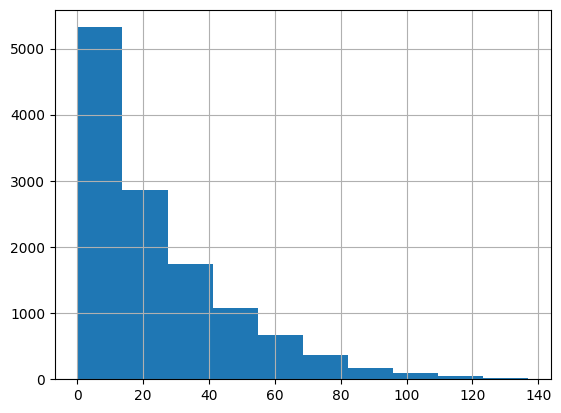

In [ ]:
df_model['wind'].hist()

### 4.1. Recursive multi-step forecasting (with weather inputs from 3 wind farms)

#### 4.2.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 261.3339982335081
RMSE: 16.16582810231224
MAE: 11.308733094120894
MAPE: 2006967083183760.5
Custom MAPE: 0.9761379286786779
Custom sMAPE: 0.3156214722860969


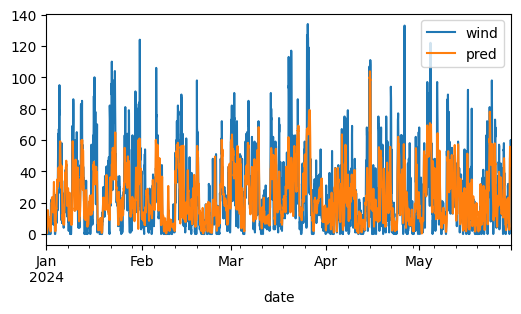

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

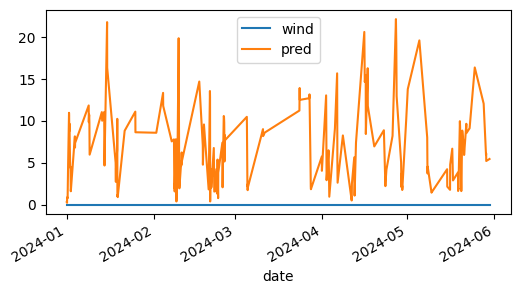

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind == 0]['wind'].plot(ax=ax)
predictions[df_test.wind == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.827625
35,wind_speed_100m_wind3,0.014359
34,wind_speed_10m_wind3,0.011929
30,wind_speed_100m_wind2,0.010120
1,lag_2,0.008661
25,wind_speed_100m_wind1,0.007990
29,wind_speed_10m_wind2,0.006105
38,wind_gusts_10m_wind3,0.005984
2,lag_3,0.005560
3,lag_4,0.005417


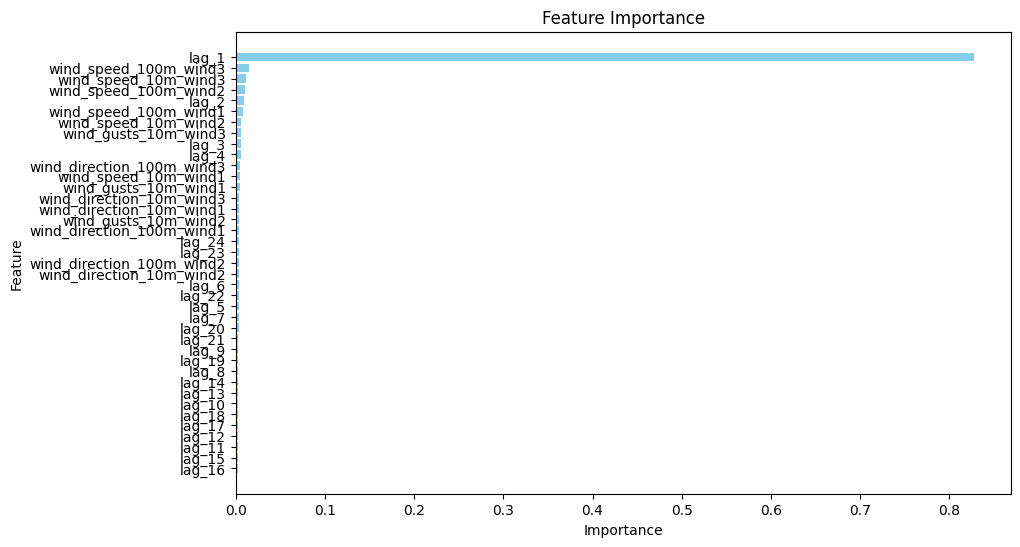

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 4.2.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, n_jobs = -1),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6385
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 39
[LightGBM] [Info] Start training from score 23.506696


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 256.4753493169296
RMSE: 16.014847776889095
MAE: 11.037076277397922
MAPE: 1785883892526817.5
Custom MAPE: 0.9293816950146968
Custom sMAPE: 0.3108251481832787


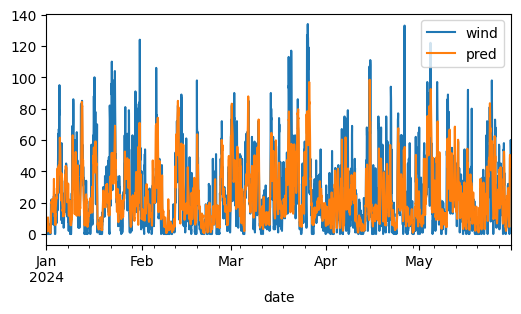

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

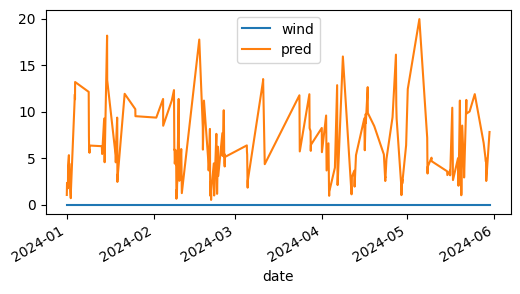

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind == 0]['wind'].plot(ax=ax)
predictions[df_test.wind == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6385
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 39
[LightGBM] [Info] Start training from score 23.506696


,feature,importance
0,lag_1,285
35,wind_speed_100m_wind3,179
25,wind_speed_100m_wind1,139
1,lag_2,136
30,wind_speed_100m_wind2,125
2,lag_3,107
34,wind_speed_10m_wind3,107
29,wind_speed_10m_wind2,89
24,wind_speed_10m_wind1,80
38,wind_gusts_10m_wind3,79


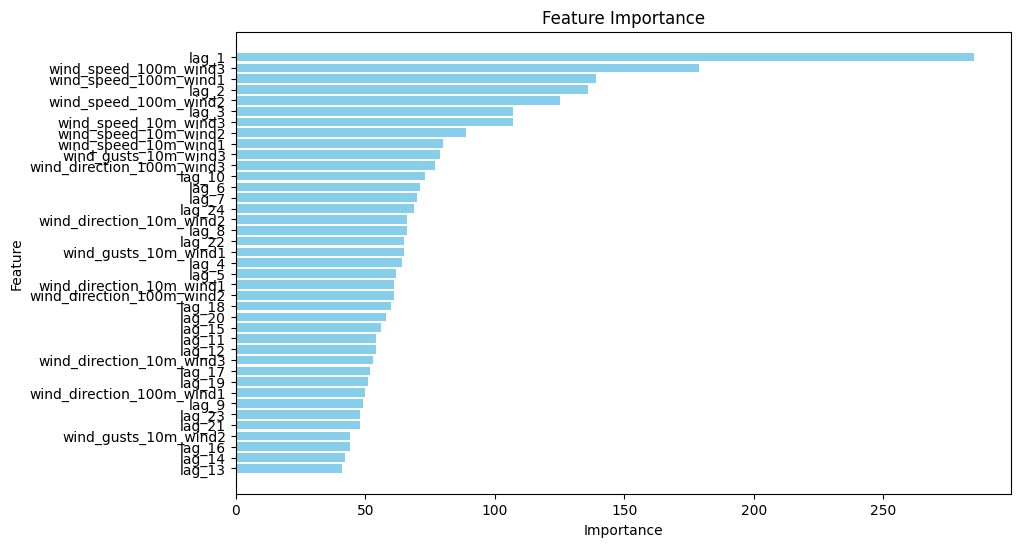

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 4.2.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123, n_jobs = -1),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 300.0577352391087
RMSE: 17.322174668300416
MAE: 11.822235781722041
MAPE: 1403857722221342.8
Custom MAPE: 0.8889220243283495
Custom sMAPE: 0.33548212980812603


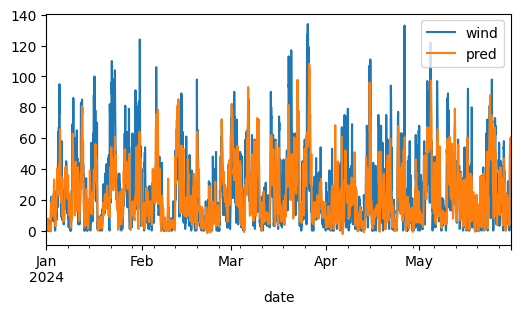

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

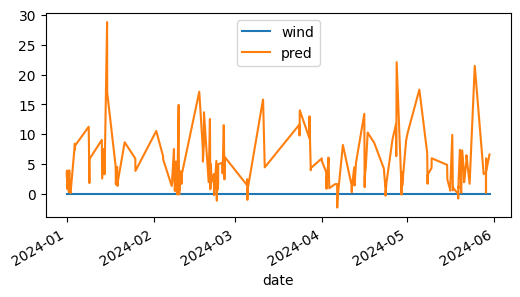

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind == 0]['wind'].plot(ax=ax)
predictions[df_test.wind == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.589612
35,wind_speed_100m_wind3,0.030081
34,wind_speed_10m_wind3,0.023321
25,wind_speed_100m_wind1,0.020106
30,wind_speed_100m_wind2,0.019186
29,wind_speed_10m_wind2,0.014415
38,wind_gusts_10m_wind3,0.013973
1,lag_2,0.012656
24,wind_speed_10m_wind1,0.012149
28,wind_gusts_10m_wind1,0.011705


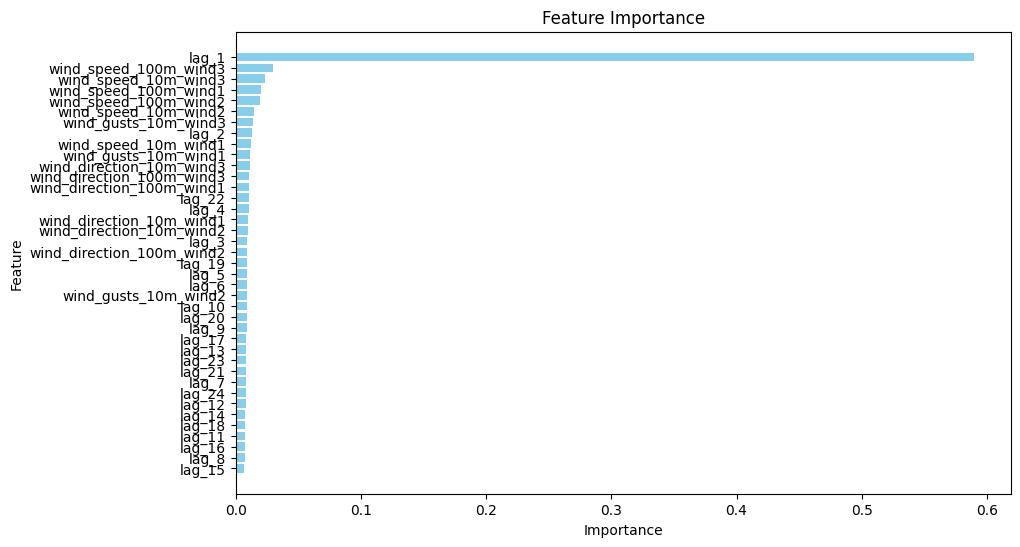

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 4.2.4. Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, n_jobs = -1),
                 lags      = 1 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 2, 3]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_total_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-17 23:30:22,404] Trial 0 finished with value: 10.999922963951084 and parameters: {'lags': 1, 'num_leaves': 142, 'max_depth': 11, 'learning_rate': 0.00492522233779106, 'n_estimators': 1473, 'min_child_samples': 70, 'min_child_weight': 0.2538981330307094, 'subsample': 0.45290576637473545, 'subsample_freq': 3, 'colsample_bytree': 0.7561447366456374, 'reg_alpha': 3.225358230874411e-05, 'reg_lambda': 3.0020863018484457e-08}. Best is trial 0 with value: 10.999922963951084.
[I 2024-07-17 23:30:31,044] Trial 1 finished with value: 10.92004675288989 and parameters: {'lags': 2, 'num_leaves': 46, 'max_depth': 8, 'learning_rate': 0.013406343673102117, 'n_estimators': 970, 'min_child_samples': 86, 'min_child_weight': 4.19060401068387, 'subsample': 0.6499211596098246, 'subsample_freq': 7, 'colsample_bytree': 0.39066302246786044, 'reg_alpha': 7.839876925917444e-06, 'reg_lambda': 6.70047894794746e-07}. Best is trial 1 with value: 10.92004675288989.
[I 2024-07-17 23:30:36,146] Trial 2 finish

In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 3, 'num_leaves': 117, 'max_depth': 13, 'learning_rate': 0.00793397634515736, 'n_estimators': 739, 'min_child_samples': 75, 'min_child_weight': 0.005119271587768954, 'subsample': 0.7899620908931794, 'subsample_freq': 7, 'colsample_bytree': 0.2329875145693367, 'reg_alpha': 1.2540722327382772e-07, 'reg_lambda': 0.006320556011736929}
10.731372872187462


In [ ]:
params = {'num_leaves': 117, 'max_depth': 13, 'learning_rate': 0.00793397634515736, 'n_estimators': 739, 'min_child_samples': 75, 'min_child_weight': 0.005119271587768954, 'subsample': 0.7899620908931794, 'subsample_freq': 7, 'colsample_bytree': 0.2329875145693367,
          'reg_alpha': 1.2540722327382772e-07, 'reg_lambda': 0.006320556011736929}


# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 3
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 244.44368879039308
RMSE: 15.634695033494996
MAE: 10.731372872187462
MAPE: 1492946010467364.0
Custom MAPE: 0.8763683724901757
Custom sMAPE: 0.3046671262525045


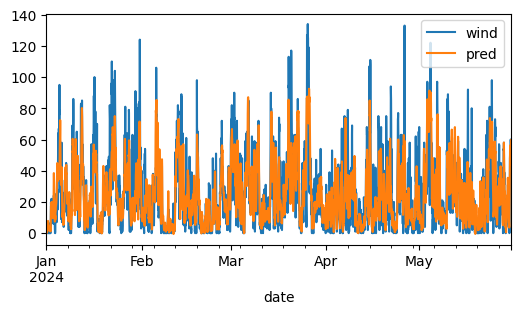

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

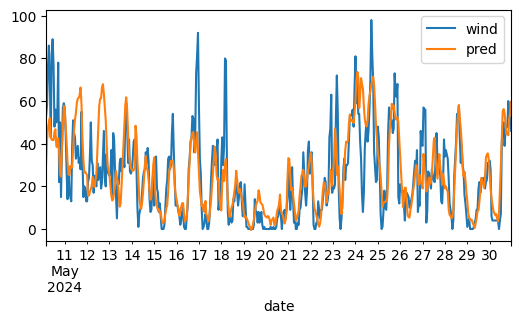

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'][-500:].plot(ax=ax)
predictions[-500:].plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

,feature,importance
6,wind_direction_100m_wind1,5192
14,wind_speed_100m_wind3,5176
10,wind_direction_10m_wind2,4812
2,lag_3,4321
16,wind_direction_100m_wind3,3741
0,lag_1,3056
4,wind_speed_100m_wind1,2727
8,wind_speed_10m_wind2,2487
12,wind_gusts_10m_wind2,2406
17,wind_gusts_10m_wind3,2334


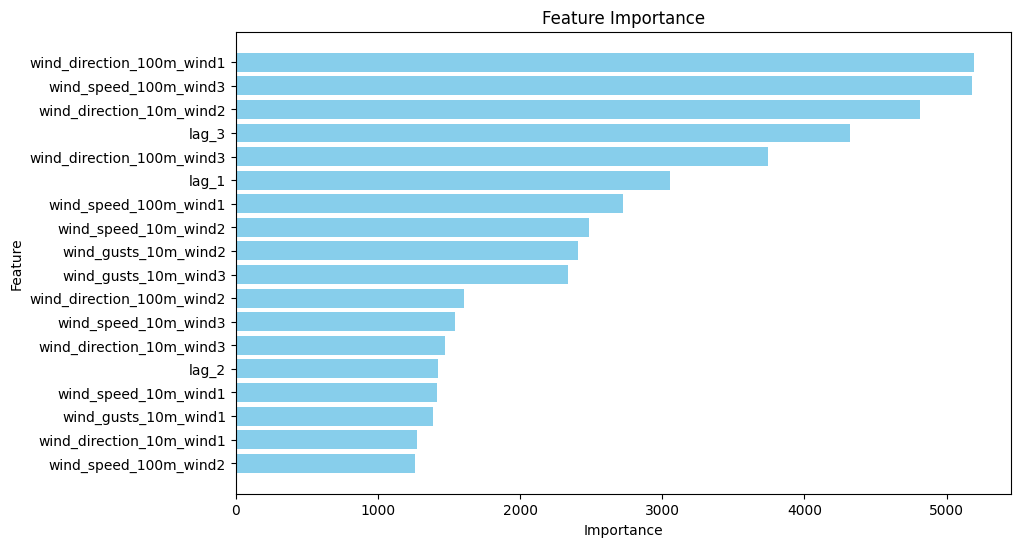

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 5.Total Generation Model

<Axes: >

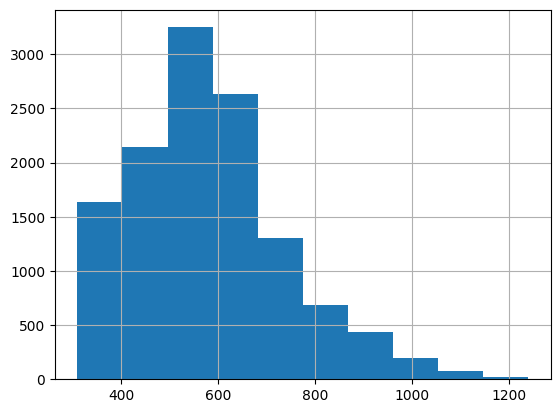

In [ ]:
df_model['total'].hist()

### 5.1. Recursive multi-step forecasting (without weather inputs)

#### 5.1.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3314.4025947005243
RMSE: 57.57084847994273
MAE: 40.55332597295059
MAPE: 0.07094224121084954
Custom MAPE: 0.07094224121084954
Custom sMAPE: 0.03640274068893682


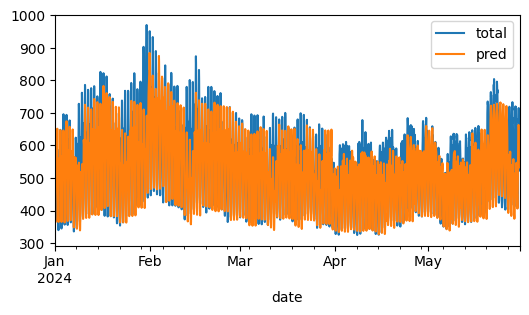

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(df_train['total'])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.905184
23,lag_24,0.055365
22,lag_23,0.015450
21,lag_22,0.004273
1,lag_2,0.001967
2,lag_3,0.001765
20,lag_21,0.001679
9,lag_10,0.001580
8,lag_9,0.001154
5,lag_6,0.001011


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


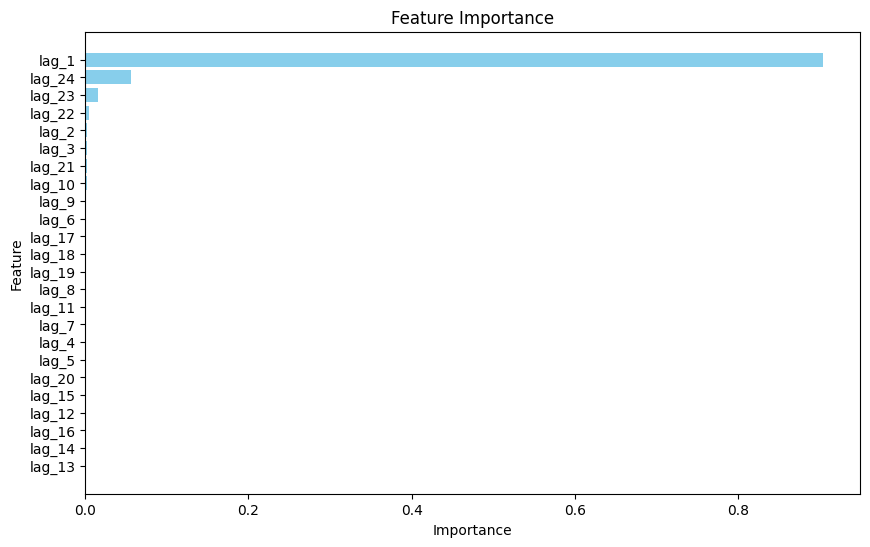

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.1.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 24
[LightGBM] [Info] Start training from score 599.458739


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3128.357570266103
RMSE: 55.93172239674104
MAE: 39.72654003007409
MAPE: 0.07000554042960287
Custom MAPE: 0.07000554042960287
Custom sMAPE: 0.03578478441117863


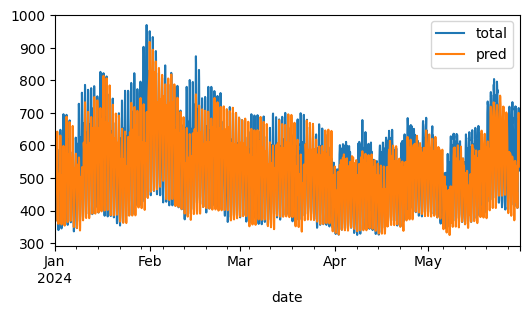

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(df_train['total'])
forecaster.get_feature_importances()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 24
[LightGBM] [Info] Start training from score 599.458739


,feature,importance
0,lag_1,617
23,lag_24,299
22,lag_23,162
2,lag_3,153
1,lag_2,150
9,lag_10,144
21,lag_22,120
8,lag_9,111
3,lag_4,105
20,lag_21,93


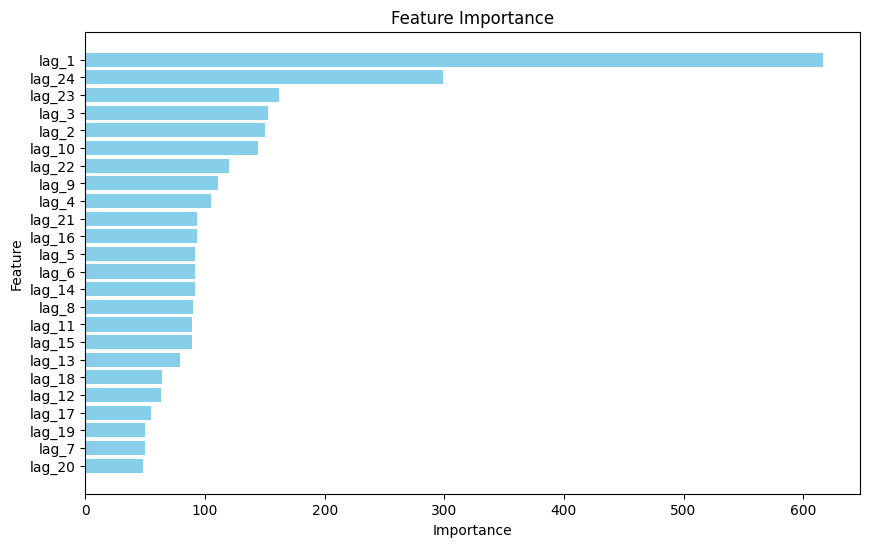

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.1.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3230.276551672847
RMSE: 56.83552191783627
MAE: 40.34952540322624
MAPE: 0.070690954847464
Custom MAPE: 0.070690954847464
Custom sMAPE: 0.03610076944703844


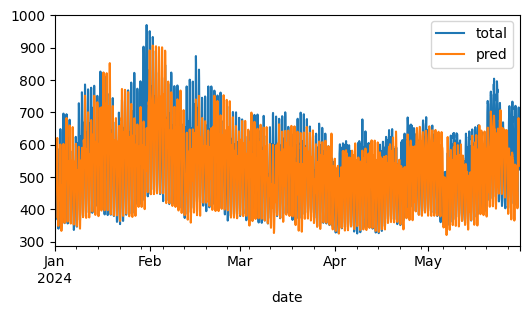

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(df_train['total'])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.795595
23,lag_24,0.081200
22,lag_23,0.045146
21,lag_22,0.012983
20,lag_21,0.008690
9,lag_10,0.006287
2,lag_3,0.005355
1,lag_2,0.005040
16,lag_17,0.004353
3,lag_4,0.003908


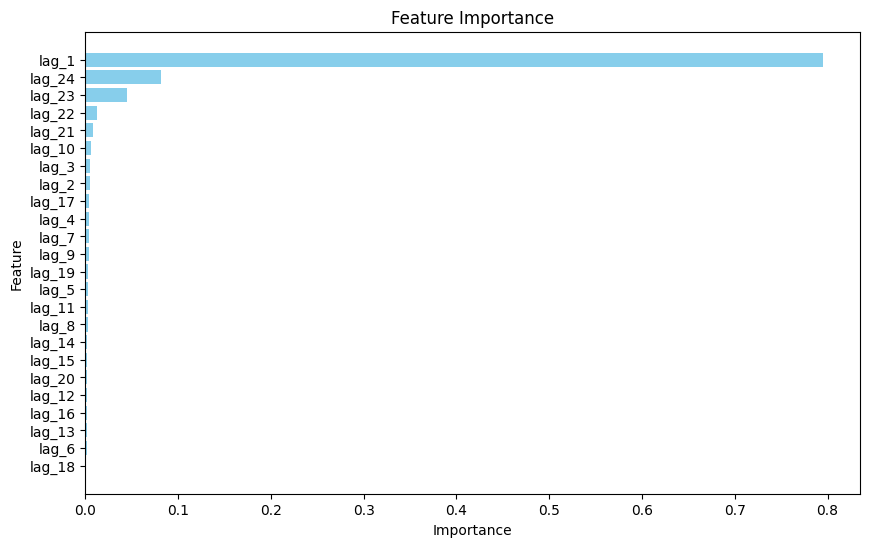

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

### 5.2. Recursive multi-step forecasting (with temp, dow, month, hour)

#### 5.2.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1802.4467312448246
RMSE: 42.45523208327596
MAE: 28.13308032017665
MAPE: 0.04882787967419496
Custom MAPE: 0.04882787967419496
Custom sMAPE: 0.02499541398269136


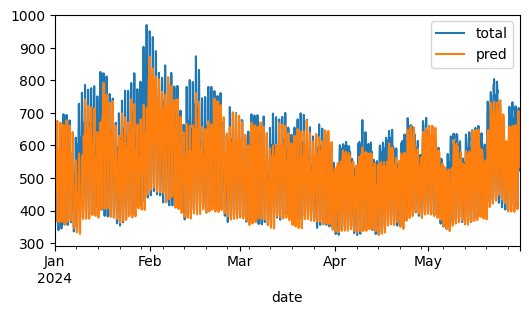

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,importance
0,lag_1,0.831922
1,lag_2,0.014615
2,lag_3,0.009591
3,lag_4,0.008827
29,hhour,0.008257
22,lag_23,0.006353
4,lag_5,0.006254
21,lag_22,0.006142
5,lag_6,0.005908
26,apparent_temperature_t3,0.005841


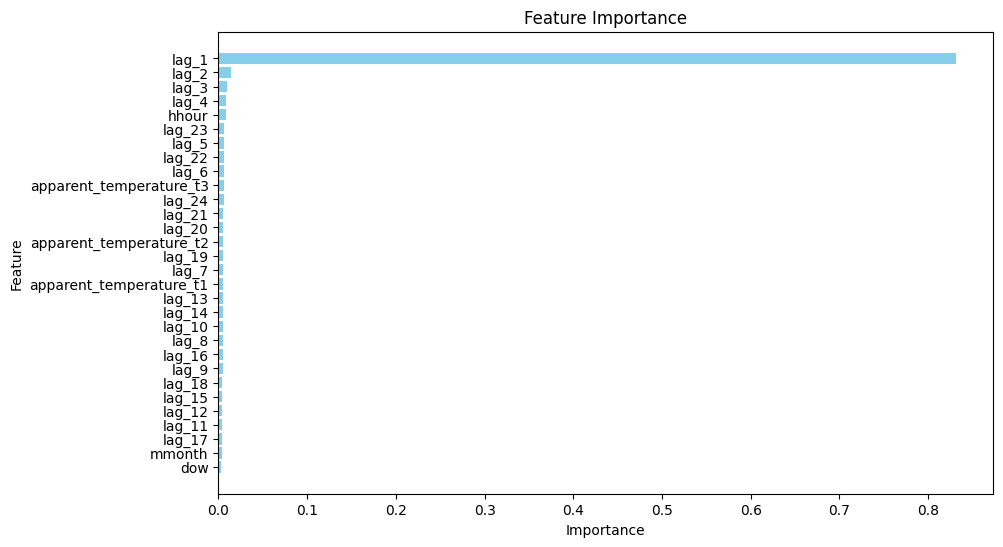

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.2.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6929
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 30
[LightGBM] [Info] Start training from score 599.458739


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1237.3022721014777
RMSE: 35.175307704432065
MAE: 24.062291969412428
MAPE: 0.042643482080816454
Custom MAPE: 0.042643482080816454
Custom sMAPE: 0.02156834968751896


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


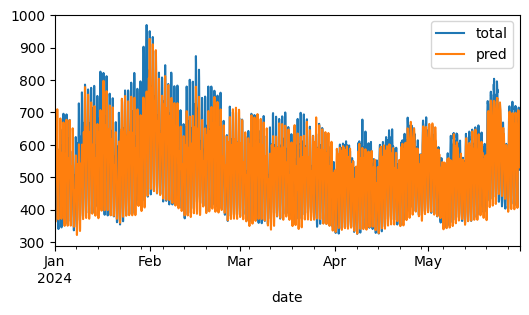

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3689
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 30
[LightGBM] [Info] Start training from score 23.506696


,feature,importance
0,lag_1,382
29,hhour,182
1,lag_2,180
2,lag_3,128
5,lag_6,118
21,lag_22,109
3,lag_4,107
24,apparent_temperature_t1,105
26,apparent_temperature_t3,103
25,apparent_temperature_t2,98


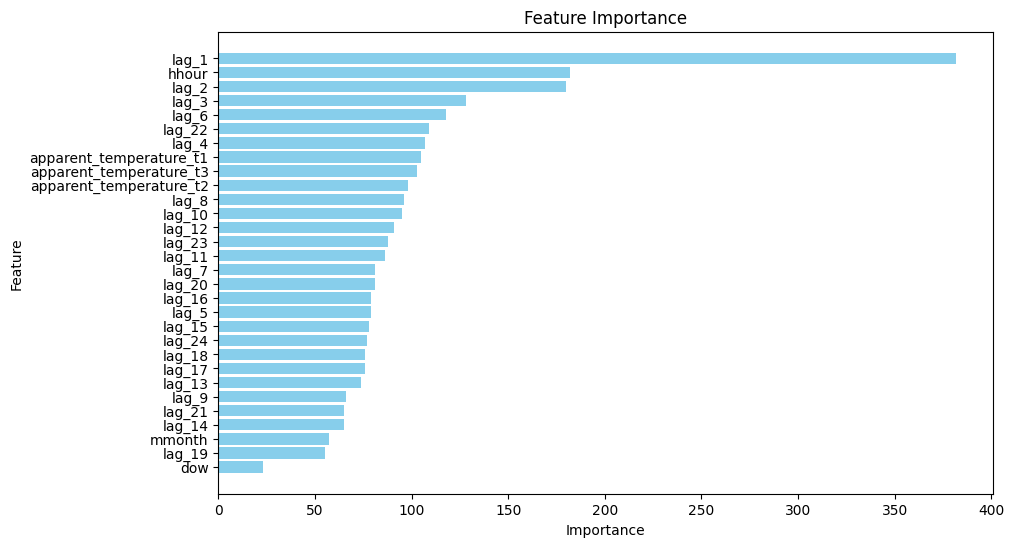

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.2.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1465.0911077225098
RMSE: 38.27650856233507
MAE: 26.21169031465906
MAPE: 0.046841573009253686
Custom MAPE: 0.046841573009253686
Custom sMAPE: 0.023778032774208525


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


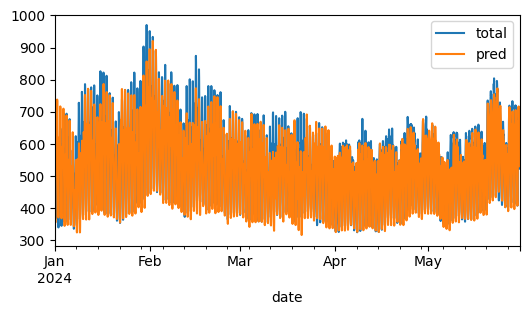

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.611468
29,hhour,0.021988
1,lag_2,0.020002
3,lag_4,0.017297
2,lag_3,0.015828
9,lag_10,0.015699
22,lag_23,0.015509
26,apparent_temperature_t3,0.015096
21,lag_22,0.014279
24,apparent_temperature_t1,0.013954


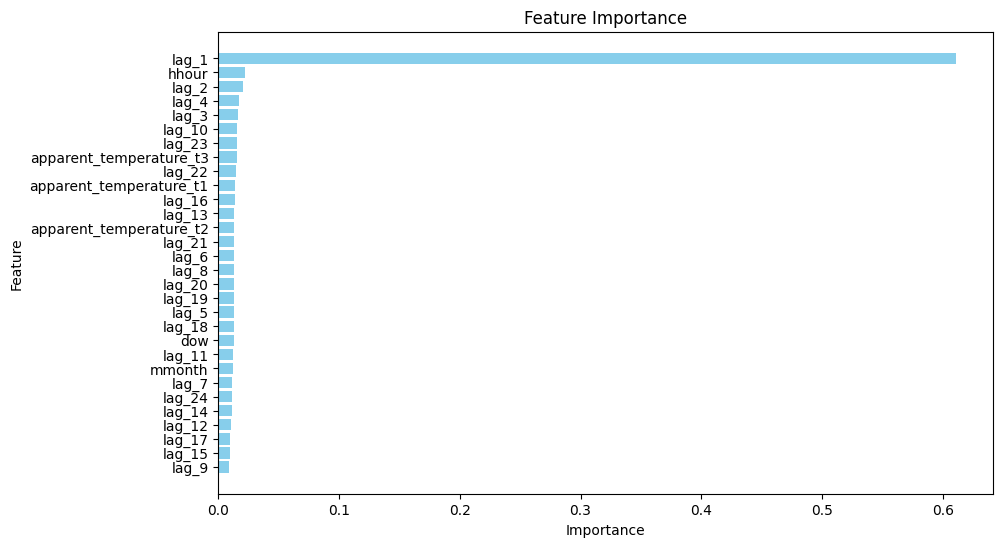

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.2.4. Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_total_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-18 06:41:10,072] Trial 0 finished with value: 25.899985660837036 and parameters: {'lags': 24, 'num_leaves': 109, 'max_depth': 16, 'learning_rate': 0.05486797781181634, 'n_estimators': 747, 'min_child_samples': 42, 'min_child_weight': 0.051986440302397775, 'subsample': 0.7561447366456374, 'subsample_freq': 4, 'colsample_bytree': 0.15371010694861154, 'reg_alpha': 1.528811858152725e-05, 'reg_lambda': 0.008016102206099943}. Best is trial 0 with value: 25.899985660837036.
[I 2024-07-18 06:41:17,886] Trial 1 finished with value: 24.036438161939895 and parameters: {'lags': 24, 'num_leaves': 218, 'max_depth': 12, 'learning_rate': 0.02780315255778501, 'n_estimators': 1098, 'min_child_samples': 36, 'min_child_weight': 0.06440851380101245, 'subsample': 0.30543690779106003, 'subsample_freq': 3, 'colsample_bytree': 0.667878511469039, 'reg_alpha': 5.455562299744123e-08, 'reg_lambda': 2.9485560066017848e-05}. Best is trial 1 with value: 24.036438161939895.
[I 2024-07-18 06:41:27,442] Trial

In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 24, 'num_leaves': 204, 'max_depth': 11, 'learning_rate': 0.009603248266030264, 'n_estimators': 929, 'min_child_samples': 87, 'min_child_weight': 0.051612316284846756, 'subsample': 0.5204685316644596, 'subsample_freq': 3, 'colsample_bytree': 0.4002773984298381, 'reg_alpha': 0.015465759255663944, 'reg_lambda': 0.0012637956046793494}
22.528936815715504


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
params = { 'num_leaves': 204, 'max_depth': 11, 'learning_rate': 0.009603248266030264, 'n_estimators': 929, 'min_child_samples': 87,
          'min_child_weight': 0.051612316284846756, 'subsample': 0.5204685316644596, 'subsample_freq': 3, 'colsample_bytree': 0.4002773984298381,
           'reg_alpha': 0.015465759255663944, 'reg_lambda': 0.0012637956046793494}



# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1078.8841394348553
RMSE: 32.84637178494537
MAE: 22.528936815715504
MAPE: 0.04039779980133667
Custom MAPE: 0.04039779980133667
Custom sMAPE: 0.02031822479399126


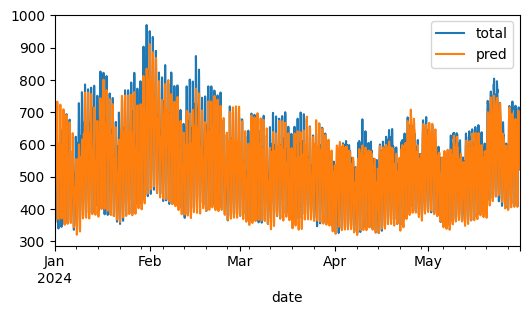

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,3367
1,lag_2,2491
2,lag_3,2037
29,hhour,1627
3,lag_4,1481
25,apparent_temperature_t2,1210
26,apparent_temperature_t3,1147
24,apparent_temperature_t1,1141
23,lag_24,1124
4,lag_5,1040


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


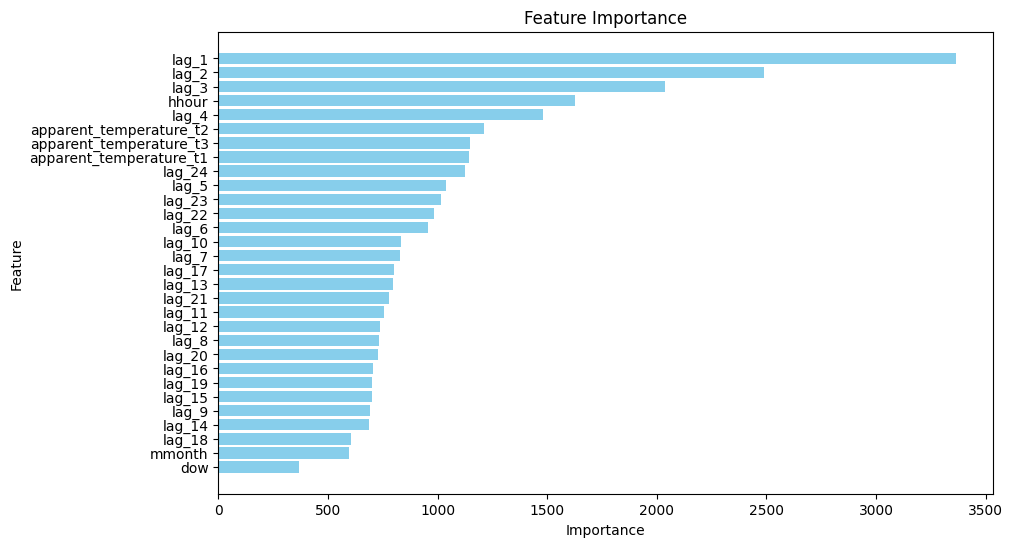

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 6.PV Generation Model

<Axes: >

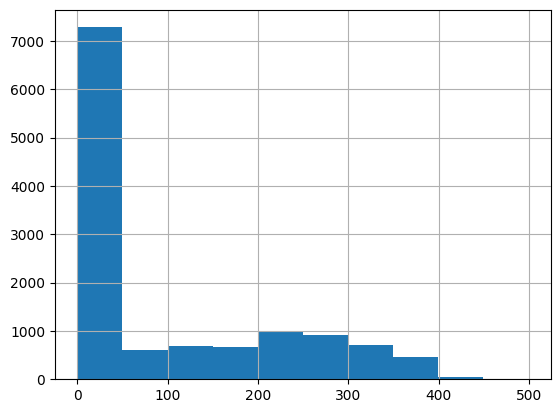

In [ ]:
df_model['pv'].hist()

### 6.1. Recursive multi-step forecasting (without weather inputs)

#### 6.1.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1958.5448911123378
RMSE: 44.25545041135993
MAE: 23.20610819762628
MAPE: 25358385978017.87
Custom MAPE: 0.19182846932877157
Custom sMAPE: 0.09148175790442016


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


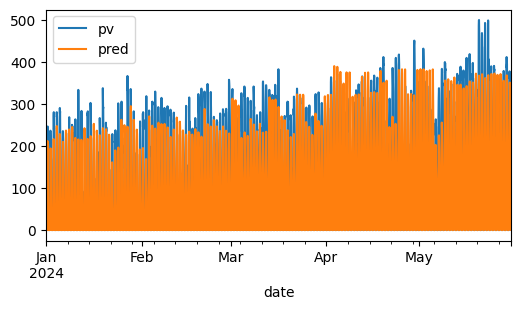

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

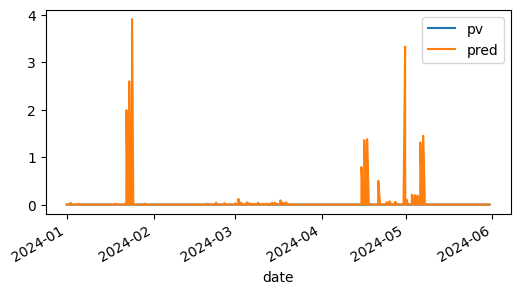

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

#### 6.1.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 24
[LightGBM] [Info] Start training from score 92.131166


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 2491.9696787084144
RMSE: 49.91963219724695
MAE: 31.17760795163781
MAPE: 2.2749852839630804e+16
Custom MAPE: 0.7340117526872197
Custom sMAPE: 0.5700525479507416


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


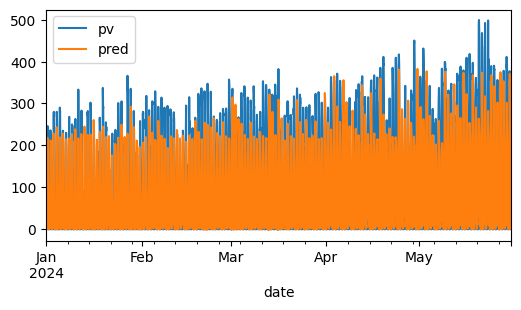

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

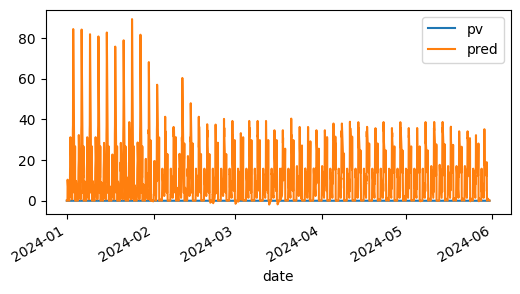

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

#### 6.1.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 2177.2187577581935
RMSE: 46.660676782042
MAE: 24.656323540159832
MAPE: 322718873619911.5
Custom MAPE: 0.6760791685234936
Custom sMAPE: 0.5600035497818915


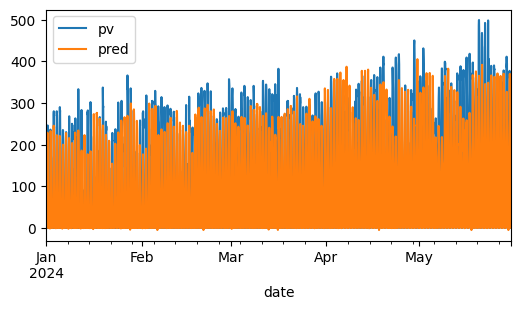

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


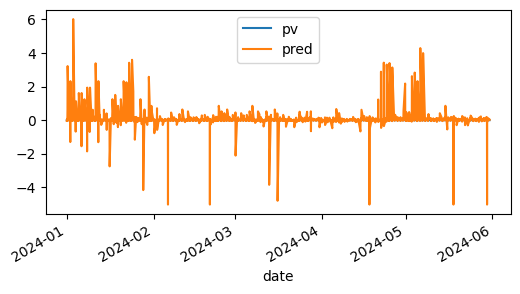

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

### 6.2. Recursive multi-step forecasting (with temp, month, hour)

#### 6.2.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1796.3069348882143
RMSE: 42.38286133436739
MAE: 22.383066519459014
MAPE: 3915633128958.754
Custom MAPE: 0.13971302952200096
Custom sMAPE: 0.07676677220222423


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


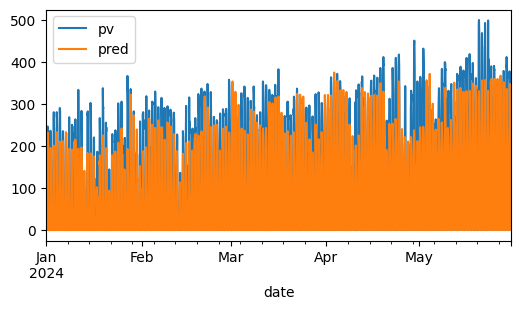

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


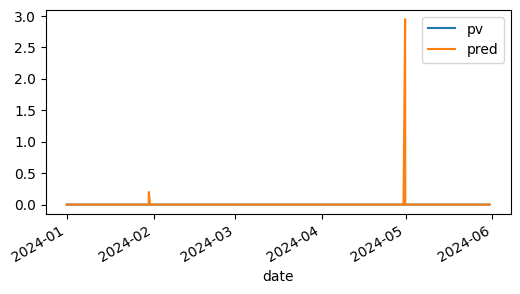

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,feature,importance
29,shortwave_radiation_instant_t2,0.595615
30,direct_radiation_instant_t2,0.179636
0,lag_1,0.060834
39,shortwave_radiation_instant_t1,0.053748
23,lag_24,0.049571
49,shortwave_radiation_instant_t3,0.018804
40,direct_radiation_instant_t1,0.013115
22,lag_23,0.004540
20,lag_21,0.003878
21,lag_22,0.003635


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


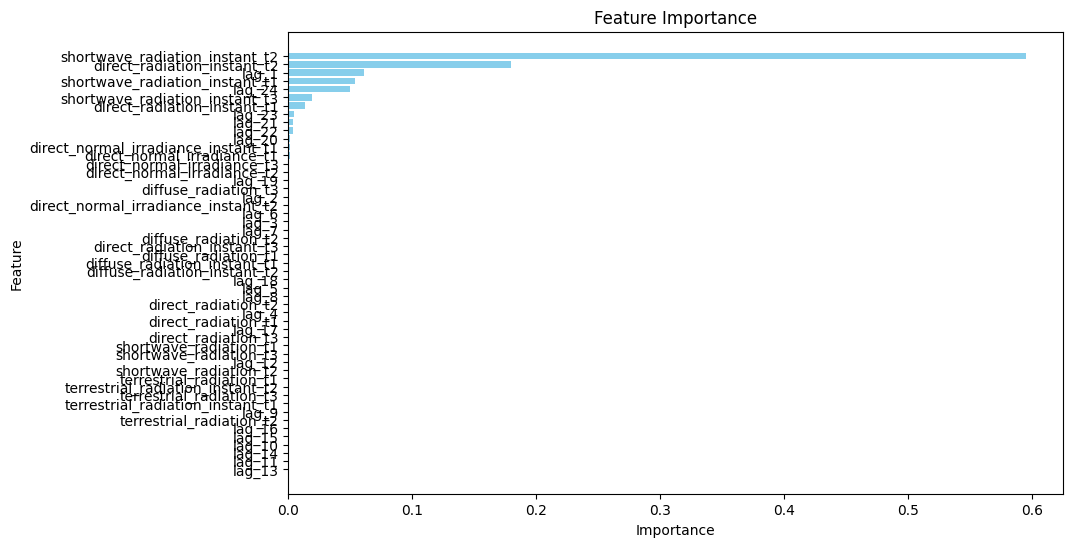

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 6.2.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 51
[LightGBM] [Info] Start training from score 92.131166


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1677.4460383744881
RMSE: 40.95663607249121
MAE: 22.024567261003018
MAPE: 2272623138889446.0
Custom MAPE: 0.6070329449012025
Custom sMAPE: 0.5455719900257059


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


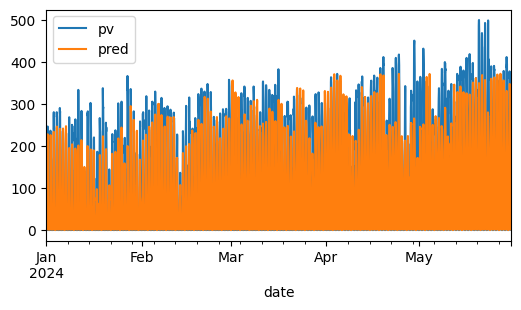

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


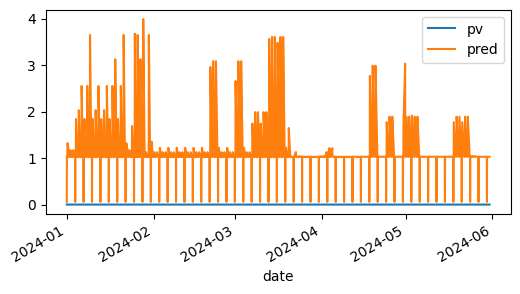

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 51
[LightGBM] [Info] Start training from score 92.131166


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,feature,importance
0,lag_1,463
23,lag_24,197
46,diffuse_radiation_t3,116
22,lag_23,113
1,lag_2,109
36,diffuse_radiation_t1,101
41,diffuse_radiation_instant_t1,94
21,lag_22,87
31,diffuse_radiation_instant_t2,86
26,diffuse_radiation_t2,85


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


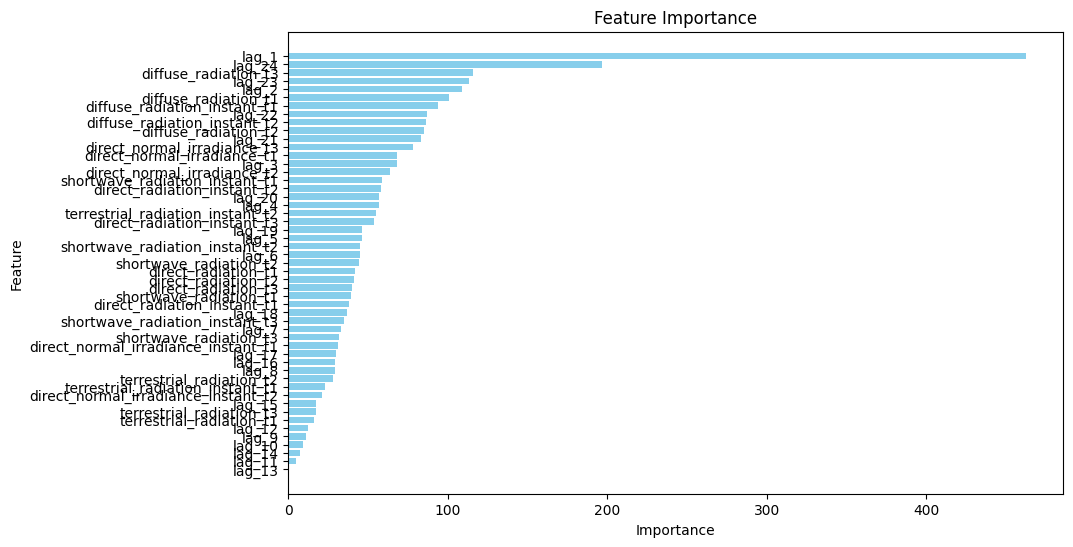

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 6.2.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 2049.9155118231565
RMSE: 45.27599266524321
MAE: 23.88277513775453
MAPE: 138268805217847.42
Custom MAPE: 0.6245877888493705
Custom sMAPE: 0.5610892806648796


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


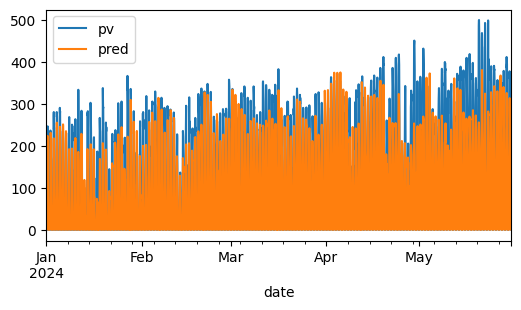

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


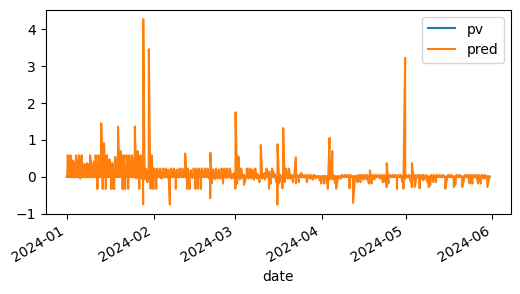

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

#### 6.2.4. Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_pv_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-18 07:14:17,839] Trial 0 finished with value: 21.713876054358597 and parameters: {'lags': 24, 'num_leaves': 109, 'max_depth': 16, 'learning_rate': 0.05486797781181634, 'n_estimators': 507, 'min_child_samples': 42, 'min_child_weight': 0.051986440302397775, 'subsample': 0.7561447366456374, 'subsample_freq': 4, 'colsample_bytree': 0.15371010694861154, 'reg_alpha': 1.528811858152725e-05, 'reg_lambda': 0.008016102206099943}. Best is trial 0 with value: 21.713876054358597.
[I 2024-07-18 07:14:26,278] Trial 1 finished with value: 22.51138402893023 and parameters: {'lags': 24, 'num_leaves': 218, 'max_depth': 12, 'learning_rate': 0.02780315255778501, 'n_estimators': 737, 'min_child_samples': 36, 'min_child_weight': 0.06440851380101245, 'subsample': 0.30543690779106003, 'subsample_freq': 3, 'colsample_bytree': 0.667878511469039, 'reg_alpha': 5.455562299744123e-08, 'reg_lambda': 2.9485560066017848e-05}. Best is trial 0 with value: 21.713876054358597.
[I 2024-07-18 07:14:39,947] Trial 2

In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 24, 'num_leaves': 214, 'max_depth': 4, 'learning_rate': 0.013396504989763285, 'n_estimators': 775, 'min_child_samples': 35, 'min_child_weight': 0.1117888285103329, 'subsample': 0.7213576918636242, 'subsample_freq': 7, 'colsample_bytree': 0.775895014720083, 'reg_alpha': 1.1328715012561808e-05, 'reg_lambda': 0.008274245340070834}
21.045591656729698


In [ ]:
params = {'num_leaves': 214, 'max_depth': 4, 'learning_rate': 0.013396504989763285, 'n_estimators': 775, 'min_child_samples': 35,
          'min_child_weight': 0.1117888285103329, 'subsample': 0.7213576918636242, 'subsample_freq': 7, 'colsample_bytree': 0.775895014720083,
          'reg_alpha': 1.1328715012561808e-05, 'reg_lambda': 0.008274245340070834}


# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1616.1041589031263
RMSE: 40.20079798838732
MAE: 21.045591656729698
MAPE: 409665889816382.56
Custom MAPE: 0.6147393140156161
Custom sMAPE: 0.5541283706625514


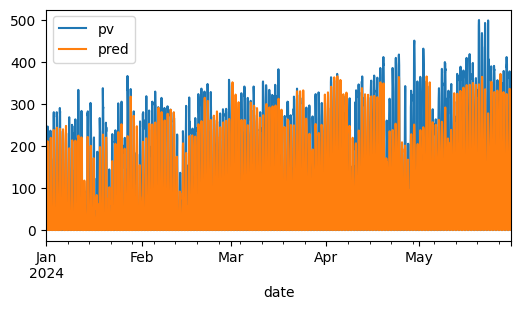

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

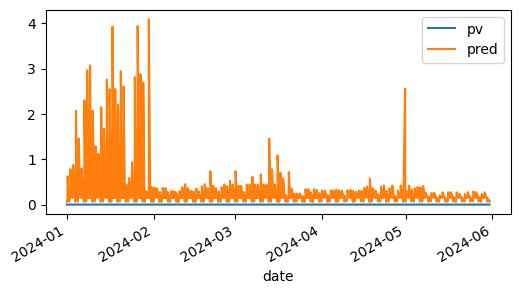

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,1799
23,lag_24,805
22,lag_23,436
1,lag_2,267
46,diffuse_radiation_t3,245
36,diffuse_radiation_t1,239
21,lag_22,217
31,diffuse_radiation_instant_t2,214
29,shortwave_radiation_instant_t2,214
39,shortwave_radiation_instant_t1,203


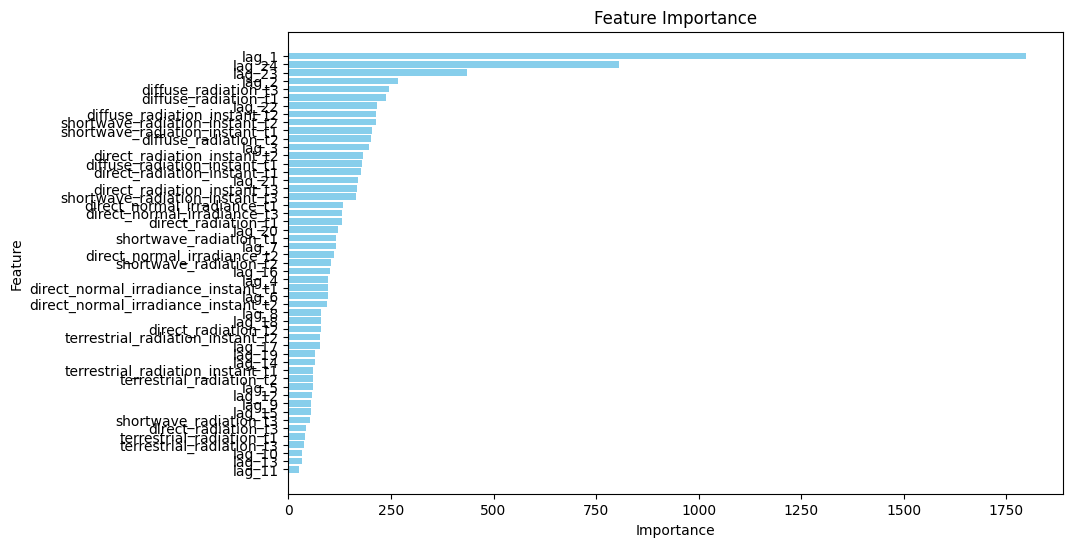

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 7.Performance Evaluation

### 7.1. Best wind model

In [ ]:
params = {'num_leaves': 117, 'max_depth': 13, 'learning_rate': 0.00793397634515736, 'n_estimators': 739, 'min_child_samples': 75, 'min_child_weight': 0.005119271587768954, 'subsample': 0.7899620908931794, 'subsample_freq': 7, 'colsample_bytree': 0.2329875145693367,
          'reg_alpha': 1.2540722327382772e-07, 'reg_lambda': 0.006320556011736929}


# Backtesting forecaster
# ==============================================================================
forecaster_wind = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 3
             )

metric, predictions_wind = backtesting_forecaster(
                          forecaster            = forecaster_wind,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 244.44368879039308
RMSE: 15.634695033494996
MAE: 10.731372872187462
MAPE: 1492946010467364.0
Custom MAPE: 0.8763683724901757
Custom sMAPE: 0.3046671262525045


In [ ]:
def correct_wind_predictions(pred_wind):
  pred_wind.pred = pred_wind.pred.apply(lambda x: 0 if x < 0 else x)
  return pred_wind.pred

In [ ]:
predictions_wind_corrected = correct_wind_predictions(predictions_wind)

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.wind, predictions_wind_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.wind, predictions_wind_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.wind, predictions_wind_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.wind, predictions_wind_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.wind, predictions_wind_corrected)))

MSE: 244.43976220531084
RMSE: 15.634569460183764
MAE: 10.730971566092604
Custom MAPE: 0.8752419054339545
Custom sMAPE: 0.3035630688415192


### 7.2. Best total model

In [ ]:
params = { 'num_leaves': 204, 'max_depth': 11, 'learning_rate': 0.009603248266030264, 'n_estimators': 929, 'min_child_samples': 87,
          'min_child_weight': 0.051612316284846756, 'subsample': 0.5204685316644596, 'subsample_freq': 3, 'colsample_bytree': 0.4002773984298381,
           'reg_alpha': 0.015465759255663944, 'reg_lambda': 0.0012637956046793494}



# Backtesting forecaster
# ==============================================================================
forecaster_total = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 24
             )

metric, predictions_total = backtesting_forecaster(
                          forecaster            = forecaster_total,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1078.8841394348553
RMSE: 32.84637178494537
MAE: 22.528936815715504
MAPE: 0.04039779980133667
Custom MAPE: 0.04039779980133667
Custom sMAPE: 0.02031822479399126


### 7.3. Best PV model

In [ ]:
params = {'num_leaves': 214, 'max_depth': 4, 'learning_rate': 0.013396504989763285, 'n_estimators': 775, 'min_child_samples': 35,
          'min_child_weight': 0.1117888285103329, 'subsample': 0.7213576918636242, 'subsample_freq': 7, 'colsample_bytree': 0.775895014720083,
          'reg_alpha': 1.1328715012561808e-05, 'reg_lambda': 0.008274245340070834}


# Backtesting forecaster
# ==============================================================================
forecaster_pv = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 24
             )

metric, predictions_pv = backtesting_forecaster(
                          forecaster            = forecaster_pv,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1616.1041589031263
RMSE: 40.20079798838732
MAE: 21.045591656729698
MAPE: 409665889816382.56
Custom MAPE: 0.6147393140156161
Custom sMAPE: 0.5541283706625514


In [ ]:
def correct_pv_predictions(pred_pv, shortwave_radiation):
  return 0 if shortwave_radiation == 0 or pred_pv < 0 else pred_pv

In [ ]:
predictions_pv_corrected = \
pd.DataFrame({'predictions_pv': predictions_pv.pred, 'shortwave_radiation_t1': df_test.shortwave_radiation_t1})

predictions_pv_corrected['predictions_pv'] = \
predictions_pv_corrected.apply(lambda row: correct_pv_predictions(row.predictions_pv, row.shortwave_radiation_t1), axis = 1)

predictions_pv_corrected = predictions_pv_corrected['predictions_pv']
predictions_pv_corrected

2024-01-01 00:00:00+02:00     0.000000
2024-01-01 01:00:00+02:00     0.000000
2024-01-01 02:00:00+02:00     0.000000
2024-01-01 03:00:00+02:00     0.000000
2024-01-01 04:00:00+02:00     0.000000
                               ...    
2024-05-30 19:00:00+03:00    38.393601
2024-05-30 20:00:00+03:00     2.141515
2024-05-30 21:00:00+03:00     0.000000
2024-05-30 22:00:00+03:00     0.000000
2024-05-30 23:00:00+03:00     0.000000
Freq: H, Name: predictions_pv, Length: 3623, dtype: float64

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.pv, predictions_pv_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.pv, predictions_pv_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.pv, predictions_pv_corrected)))

MSE: 1616.0444137638283
RMSE: 40.20005489752257
MAE: 20.955332533543377
Custom MAPE: 0.13999462729190656
Custom sMAPE: 0.07938368393884171


In [ ]:
df_EnMix_historical_predictions = pd.DataFrame({
    'total': predictions_total.pred,
    'wind': predictions_wind_corrected,
    'oil': 0,
    'gas': 0,
    'coal':0,
    'biomass' : 8,
    'pv': predictions_pv_corrected,
    'water':0
}, index=df_test.index)
df_EnMix_historical_predictions['oil'] = df_EnMix_historical_predictions.apply(lambda row: row.total - row.wind - row.biomass - row.pv, axis = 1)
df_EnMix_historical_predictions

,total,wind,oil,gas,coal,biomass,pv,water
date,,,,,,,,
2024-01-01 00:00:00+02:00,441.317963,4.246074,429.071889,0,0,8,0.000000,0
2024-01-01 01:00:00+02:00,398.838291,4.962702,385.875589,0,0,8,0.000000,0
2024-01-01 02:00:00+02:00,371.786197,4.489968,359.296229,0,0,8,0.000000,0
2024-01-01 03:00:00+02:00,361.054885,2.715888,350.338997,0,0,8,0.000000,0
2024-01-01 04:00:00+02:00,358.930850,1.507340,349.423510,0,0,8,0.000000,0
...,...,...,...,...,...,...,...,...
2024-05-30 19:00:00+03:00,640.812337,45.332927,549.085809,0,0,8,38.393601,0
2024-05-30 20:00:00+03:00,630.239581,43.958601,576.139465,0,0,8,2.141515,0
2024-05-30 21:00:00+03:00,608.480289,51.772700,548.707589,0,0,8,0.000000,0


### 7.4. Evaluation

In [ ]:
# Emission factors from electricitymaps.com
# https://www.electricitymaps.com/methodology?utm_source=app.electricitymaps.com&utm_medium=referral#carbon-intensity-and-emission-factors
# https://docs.google.com/spreadsheets/d/1ukTAD_oQKZfq-FgLpbLo_bGOv-UPTaoM_WS316xlDcE/edit?gid=316937240#gid=316937240
emission_factors_df = pd.read_csv(google_drive_path + "ElectricityMapsEmissionFactors.csv")
emission_factors_df.head(5)

,zone_key,emission_factor_type,production_mode,datetime,value,source
0,CA-ON,lifecycle,gas,6/10/2024 0:00:00,497.0,"Mallia, E., Lewis, G. ""Life cycle greenhouse g..."
1,US-NW-BPAT,direct,gas,6/10/2024 0:00:00,385.5,eGrid 2021
2,AD,direct,gas,6/10/2024 0:00:00,370.0,IPCC 2014
3,AE,direct,gas,6/10/2024 0:00:00,370.0,IPCC 2014
4,AF,direct,gas,6/10/2024 0:00:00,370.0,IPCC 2014


In [ ]:
def get_carbon_footprint(energy_mix_df, emissions_df, country_code, emission_type):

  df = emissions_df[(emissions_df["zone_key"] == country_code) & (emissions_df['emission_factor_type'] == emission_type)]

  energy_mix_df["gCO2eq_footprint_per_KWh"] = energy_mix_df.apply(
      lambda row: (row.wind * df[df.production_mode == "wind"].iloc[0].value +
                  row.oil * df[df.production_mode == "oil"].iloc[0].value +
                  row.gas * df[df.production_mode == "gas"].iloc[0].value +
                  row.coal * df[df.production_mode == "coal"].iloc[0].value +
                  row.biomass * df[df.production_mode == "biomass"].iloc[0].value +
                  row.pv * df[df.production_mode == "solar"].iloc[0].value +
                  row.water * df[df.production_mode == "hydro discharge"].iloc[0].value) /
                  row.total,
      axis = 1
  )

  return energy_mix_df

In [ ]:
df_cy_historical_carbon_footprint_predicted = \
get_carbon_footprint(df_EnMix_historical_predictions, emission_factors_df, "CY", "lifecycle")
df_cy_historical_carbon_footprint_predicted

,total,wind,oil,gas,coal,biomass,pv,water,gCO2eq_footprint_per_KWh
date,,,,,,,,,
2024-01-01 00:00:00+02:00,441.317963,4.246074,429.071889,0,0,8,0.000000,0,931.439153
2024-01-01 01:00:00+02:00,398.838291,4.962702,385.875589,0,0,8,0.000000,0,927.387009
2024-01-01 02:00:00+02:00,371.786197,4.489968,359.296229,0,0,8,0.000000,0,926.675447
2024-01-01 03:00:00+02:00,361.054885,2.715888,350.338997,0,0,8,0.000000,0,930.498545
2024-01-01 04:00:00+02:00,358.930850,1.507340,349.423510,0,0,8,0.000000,0,933.530166
...,...,...,...,...,...,...,...,...,...
2024-05-30 19:00:00+03:00,640.812337,45.332927,549.085809,0,0,8,38.393601,0,822.407225
2024-05-30 20:00:00+03:00,630.239581,43.958601,576.139465,0,0,8,2.141515,0,875.638333
2024-05-30 21:00:00+03:00,608.480289,51.772700,548.707589,0,0,8,0.000000,0,864.031958


In [ ]:
df_cy_historical_carbon_footprint = \
pd.read_csv(google_drive_path + "CabonFootprint_CY_historical_estimated_01-01-2022_30-05-2024.csv", index_col = 0).\
set_index('timestamp').tail(3623)
df_cy_historical_carbon_footprint

,total,wind,oil,gas,coal,biomass,pv,water,gCO2eq_footprint_per_KWh
timestamp,,,,,,,,,
2024-01-01 00:00:00+02:00,466.0,0.0,456.0,0,0,10.0,0.0,0,938.081888
2024-01-01 01:00:00+02:00,446.0,0.0,436.0,0,0,10.0,0.0,0,937.385561
2024-01-01 02:00:00+02:00,426.0,0.0,416.0,0,0,10.0,0.0,0,936.623850
2024-01-01 03:00:00+02:00,396.0,0.0,386.0,0,0,10.0,0.0,0,935.337020
2024-01-01 04:00:00+02:00,373.0,0.0,363.0,0,0,10.0,0.0,0,934.210268
...,...,...,...,...,...,...,...,...,...
2024-05-30 19:00:00+03:00,621.0,48.0,530.0,0,0,6.0,36.0,0,818.551787
2024-05-30 20:00:00+03:00,618.0,60.0,549.0,0,0,6.0,3.0,0,850.721505
2024-05-30 21:00:00+03:00,620.0,53.0,558.0,0,0,9.0,0.0,0,862.666516


<Axes: >

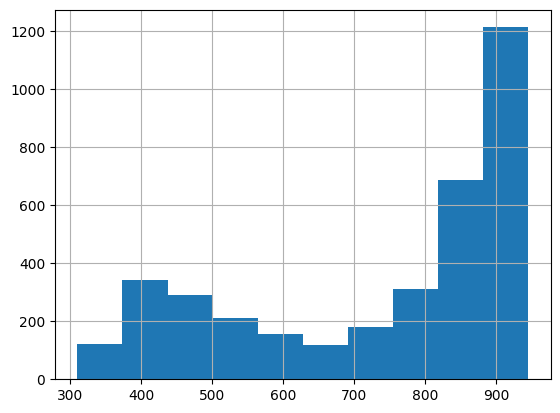

In [ ]:
df_cy_historical_carbon_footprint.gCO2eq_footprint_per_KWh.hist()

In [ ]:
df_cy_historical_carbon_footprint.gCO2eq_footprint_per_KWh.reset_index(drop = True)

0       938.081888
1       937.385561
2       936.623850
3       935.337020
4       934.210268
           ...    
3618    818.551787
3619    850.721505
3620    862.666516
3621    856.849145
3622    858.393881
Name: gCO2eq_footprint_per_KWh, Length: 3623, dtype: float64

In [ ]:
df_cy_historical_carbon_footprint_predicted.gCO2eq_footprint_per_KWh.reset_index(drop = True)

0       931.439153
1       927.387009
2       926.675447
3       930.498545
4       933.530166
           ...    
3618    822.407225
3619    875.638333
3620    864.031958
3621    852.534785
3622    835.703732
Name: gCO2eq_footprint_per_KWh, Length: 3623, dtype: float64

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_cy_historical_carbon_footprint.gCO2eq_footprint_per_KWh, df_cy_historical_carbon_footprint_predicted.gCO2eq_footprint_per_KWh)))
print("RMSE: " + str(mean_squared_error(df_cy_historical_carbon_footprint.gCO2eq_footprint_per_KWh, df_cy_historical_carbon_footprint_predicted.gCO2eq_footprint_per_KWh)**0.5))
print("MAE: " +  str(mean_absolute_error(df_cy_historical_carbon_footprint.gCO2eq_footprint_per_KWh, df_cy_historical_carbon_footprint_predicted.gCO2eq_footprint_per_KWh)))
print("Custom MAPE: " +  str(custom_mape(df_cy_historical_carbon_footprint.gCO2eq_footprint_per_KWh.reset_index(drop = True),
                                         df_cy_historical_carbon_footprint_predicted.gCO2eq_footprint_per_KWh.reset_index(drop = True))))
print("Custom sMAPE: " +  str(custom_smape(df_cy_historical_carbon_footprint.gCO2eq_footprint_per_KWh.reset_index(drop = True),
                                         df_cy_historical_carbon_footprint_predicted.gCO2eq_footprint_per_KWh.reset_index(drop = True))))

MSE: 4123.340352776062
RMSE: 64.2132412573611
MAE: 43.42529537672499
Custom MAPE: 0.07975884028090953
Custom sMAPE: 0.036956857159679356


# How to predict:
- Needs lags based on the lags the model was trained
- Needs exogenous parameters the same number as the steps ahead to be forecasted
- Both should be indexed based on datetimes

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, num_leaves = 126, max_depth = 16, learning_rate = 0.006560371025154591,
                                           n_estimators = 877, min_child_samples = 95, min_child_weight = 0.006273241404256478, subsample = 0.6423580505833233,
                                           subsample_freq = 7, colsample_bytree = 0.2007842480609956, reg_alpha = 0.0003656058725013657,
                                           reg_lambda = 1.7710459138844433e-06, verbose = -1),
                 lags      = 2
             )

In [ ]:
forecaster.fit(df_train['pv'],
               exog = df_train[['apparent_temperature_pv1']])

In [ ]:
# Creating an hourly date range
hourly_date_range = pd.date_range(start='2024-06-30', periods=24, freq='H')

# Creating the Series
pv_series = pd.Series(
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    index=hourly_date_range,
    name='pv'
).tail(2)
pv_series

2024-06-30 22:00:00    23
2024-06-30 23:00:00    24
Freq: H, Name: pv, dtype: int64

In [ ]:
hourly_date_range = pd.date_range(start='2024-07-01', periods=3, freq='H')

df = pd.DataFrame({
    'apparent_temperature_pv1': [21, 22, 23]
}, index = hourly_date_range)
df

,apparent_temperature_pv1
2024-07-01 00:00:00,21
2024-07-01 01:00:00,22
2024-07-01 02:00:00,23


In [ ]:
forecaster.predict(steps = 3, exog = df.head(3), last_window = pv_series.tail(2) )

2024-07-01 00:00:00    57.901594
2024-07-01 01:00:00    70.404865
2024-07-01 02:00:00    80.551832
Freq: H, Name: pred, dtype: float64

## 4.1. Feature selection

In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
from skforecast.datasets import fetch_dataset

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import select_features

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import select_features_multiseries

In [ ]:
# Create forecaster
# ==============================================================================
regressor = LGBMRegressor(
                n_estimators = 100,
                max_depth = 5,
                random_state = 15926,
                verbose = -1
            )

forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags = 72
             )

# Recursive feature elimination with cross-validation
# ==============================================================================
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 5,
    min_features_to_select = 1,
    n_jobs                 = -1
)
selected_lags, selected_exog = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = df_train['wind'],
    exog            = df_train.drop(columns = ['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']),
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.2,
    random_state    = 123,
    verbose         = True,
)

In [ ]:
# Feature selection (autoregressive and exog) with SelectFromModel + SequentialFeatureSelector
# ==============================================================================
regressor = LGBMRegressor(n_estimators=100, max_depth=5, random_state=15926, verbose=-1)

# Step 1: Select the 70% most important features with SelectFromModel
selector_1 = SelectFromModel(
                 estimator    = regressor,
                 max_features = int(df_train.shape[1] * 0.5),
                 threshold    = -np.inf
             )
selected_autoreg_1, selected_exog_1 = select_features(
    forecaster  = forecaster,
    selector    = selector_1,
    y           = df_train['wind'],
    exog        = df_train.drop(columns = ['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']),
    select_only = None,
    subsample   = 0.2,
    verbose     = True,
)
print("")

# Step 2: Select the 25 most important features with SequentialFeatureSelector
forecaster.set_lags(lags=selected_autoreg_1)
selector_2 = SequentialFeatureSelector(
                 estimator            = regressor,
                #  n_features_to_select = 1,
                 direction            = "forward",
                 cv                   = ShuffleSplit(n_splits=1, test_size=0.3, random_state=951),
                 scoring              = "neg_mean_absolute_error",
                 n_jobs               = -1,
             )

# selector_2 = RFECV(
#     estimator              = regressor,
#     step                   = 1,
#     cv                     = 5,
#     min_features_to_select = 1,
#     n_jobs                 = -1
# )


selected_autoreg, selected_exog = select_features(
    forecaster  = forecaster,
    selector    = selector_2,
    y           = df_train['wind'],
    exog        = df_train[selected_exog_1],
    select_only = None,
    subsample   = 0.5,
    verbose     = True,
)

Recursive feature elimination (SelectFromModel)
-----------------------------------------------
Total number of records available: 8690
Total number of records used for feature selection: 1738
Number of features available: 306
    Autoreg (n=51)
    Exog    (n=255)
Number of features selected: 131
    Autoreg (n=51) : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 43, 45, 46, 47, 48, 52, 56, 57, 59, 61, 62, 63, 64, 65, 67, 68, 69, 71]
    Exog    (n=80) : ['relative_humidity_2m_wind1', 'apparent_temperature_wind1', 'pressure_msl_wind1', 'surface_pressure_wind1', 'cloud_cover_wind1', 'cloud_cover_mid_wind1', 'wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1', 'temperature_2m_wind2', 'relative_humidity_2m_wind2', 'apparent_temperature_wind2', 'precipitation_wind2', 'surface_pressure_wind2', 'cloud_cover_wind2', 'cloud_cover_low_wind2',